In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

import numpy as np
import tensorflow.compat.v1 as tf
import random as python_random

random_state = 124
np.random.seed( random_state )
python_random.seed( random_state )
tf.set_random_seed( random_state )

In [2]:
from pandas import read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow.compat.v1 as tf

In [3]:
df = read_csv('international-airline-passengers.csv',usecols=[1])

In [4]:
df.describe()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
values = df.values.astype(np.float32)
values.shape

(144, 1)

In [6]:
train_size = int(values.shape[0]*0.67)
test_size = values.shape[0]-train_size
train_size,test_size

(96, 48)

In [7]:
train = values[:train_size]
test = values[train_size:]

In [8]:
scaler = MinMaxScaler(feature_range =(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [9]:
def create_dataset(data,k=4):
    dataX,dataY=[],[]
    for i in range(data.shape[0]-k):
        x=data[i:i+k ,0]
        y=data[i+k,0] ## Note that data is a 2d Matrix 
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX),np.array(dataY)

In [10]:
look_back =12
trainX,trainY = create_dataset(train,look_back)  
testX,testY = create_dataset(test,look_back)

In [160]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense,LSTM,GRU

In [161]:
print("Earlier :",trainX.shape,testX.shape)
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
print("Earlier :",trainX.shape,testX.shape)

Earlier : (84, 12, 1) (36, 12, 1)
Earlier : (84, 12, 1) (36, 12, 1)


In [162]:
model = Sequential()

rnn_units = 4
n_features = 1 ## as in our case ?? 
model.add(SimpleRNN(rnn_units,input_shape=(look_back,n_features)))

out_units = 1
model.add(Dense(out_units))

model.compile(loss = 'mean_squared_error',optimizer = 'adam')


In [262]:
model = Sequential()
rnn_units = 8 
n_features = 1 ## as in our case ?? 
# model.add(SimpleRNN(rnn_units,input_shape=(look_back,n_features)))
# model.add(GRU(rnn_units,input_shape=(look_back,n_features)))
model.add(LSTM(rnn_units,input_shape=(look_back,n_features)))
# 

h1_units = 16
model.add(Dense(h1_units,activation=keras.activations.tanh))
out_units = 1
model.add(Dense(out_units))

# def R2_score(y_true, y_pred):  ## R2 score is useless as doesnot contain 
#     total_error = tf.reduce_sum( tf.square( y_true - tf.reduce_mean(y_true)) )
#     unexplained_error = tf.reduce_sum(tf.square( (y_true - y_pred)) )
#     r2 = 1-(unexplained_error / total_error) 
#     return r2 
# metrics=[R2_score]
model.compile(loss = 'mean_squared_error',optimizer ='adam')


In [263]:
epochs = 50
batch_size = 1
model.fit(trainX ,trainY ,epochs= epochs,batch_size=batch_size)

Epoch 1/50
84/84 [==============================] - 4s 6ms/step - loss: 0.0332
Epoch 2/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 3/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0133
Epoch 4/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0143
Epoch 5/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 6/50
84/84 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 7/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0126
Epoch 8/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0117
Epoch 9/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0120
Epoch 10/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 11/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 12/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 13/50
84/84 [==============================

In [264]:
from sklearn.metrics import r2_score

testPredict = model.predict(testX)
trainPredict = model.predict(trainX)

print(r2_score(trainY,trainPredict)) ## Not r2 score is not affected by min max scalling 
print(r2_score(testY,testPredict))   ## also it can evaluate score for 2d targets as well

3/3 [==============================] - 0s 5ms/step
0.9230380175936337
0.67176737404543


In [265]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)

print(testPredict.shape)

testPredict = testPredict.ravel()
print(testPredict.shape)

2/2 [==============================] - 0s 6ms/step
(36, 1)
(36,)


In [266]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)

print(trainPredict.shape)

trainPredict = trainPredict.ravel()
print(trainPredict.shape)

3/3 [==============================] - 0s 5ms/step
(84, 1)
(84,)


In [267]:
## Note  scaler was applied on 2d data but testY is only 1d so add bracket on side of it to make it 2d.
testTrue = scaler.inverse_transform([testY]).ravel()
trainTrue = scaler.inverse_transform([trainY]).ravel()
print(trainTrue.shape,testTrue.shape)

(84,) (36,)


In [268]:
from matplotlib import pyplot as plt

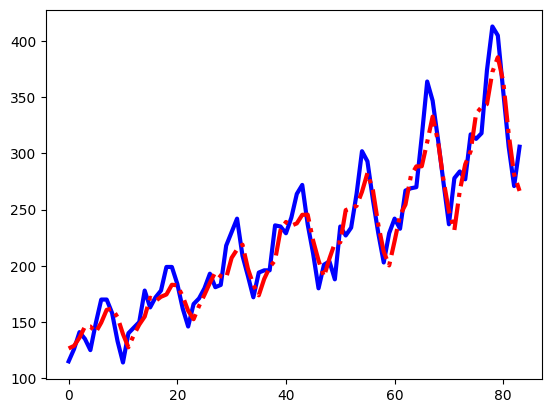

In [269]:
plt.plot(trainTrue,'b',linewidth=3)
plt.plot(trainPredict,'r-.',linewidth=3)

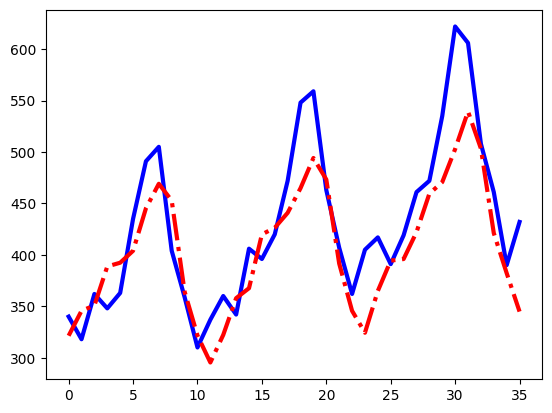

In [270]:
plt.plot(testTrue,'b',linewidth=3)
plt.plot(testPredict,'r-.',linewidth=3)

In [271]:
combinedPredicted = np.concatenate([trainPredict,testPredict])
combinedTrue = np.concatenate([trainTrue,testTrue])

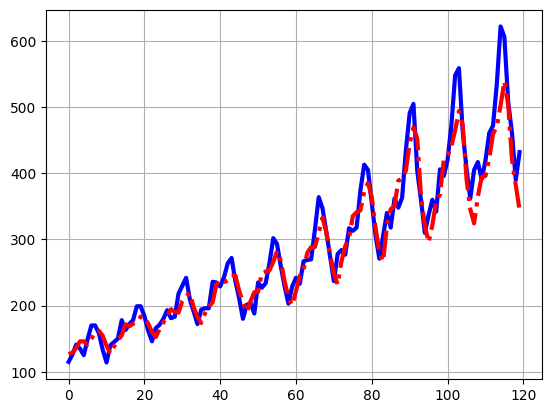

In [272]:
plt.plot(combinedTrue,'b',linewidth=3)
plt.plot(combinedPredicted,'r-.',linewidth=3)
plt.grid()